<a href="https://colab.research.google.com/github/DataVoyager220/product_analytics_projects/blob/main/Olist_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [2]:
# Установка gdown
!pip install gdown

In [3]:
# Скачивание файла с Google Drive
import gdown

file_id = "1QrHE0tSzHVKbyq0in9OfslTAKXJYU6O1"
url = f"https://drive.google.com/uc?id={file_id}"
output = "data.zip"  # Имя скачанного архива
gdown.download(url, output, quiet=False)  # Скачиваем

Downloading...
From (original): https://drive.google.com/uc?id=1QrHE0tSzHVKbyq0in9OfslTAKXJYU6O1
From (redirected): https://drive.google.com/uc?id=1QrHE0tSzHVKbyq0in9OfslTAKXJYU6O1&confirm=t&uuid=7e3ddeaf-9263-4cc8-a6a1-8535dc074a64
To: /content/data.zip
100%|██████████| 44.7M/44.7M [00:00<00:00, 47.1MB/s]


'data.zip'

In [4]:
import zipfile
import os

# Распаковываем в папку 'data'
with zipfile.ZipFile("data.zip", 'r') as zip_ref:
    zip_ref.extractall("data")

# Проверяем, какие файлы внутри
csv_files = [f for f in os.listdir("data") if f.endswith('.csv')]
print("Найдены CSV-файлы:", csv_files)

Найдены CSV-файлы: ['olist_order_payments_dataset.csv', 'olist_geolocation_dataset.csv', 'olist_order_reviews_dataset.csv', 'olist_customers_dataset.csv', 'product_category_name_translation.csv', 'olist_order_items_dataset.csv', 'olist_sellers_dataset.csv', 'olist_orders_dataset.csv', 'olist_products_dataset.csv']


In [5]:
# Создаем словарь для хранения DataFrame
dataframes = {}

for file in csv_files:
    df_name = file.replace('.csv', '')  # Убираем расширение для имени переменной
    dataframes[df_name] = pd.read_csv(f"data/{file}")

    # Выводим информацию о файле
    print(f"\n📊 Файл: {file}")
    print("Колонки:", list(dataframes[df_name].columns))


📊 Файл: olist_order_payments_dataset.csv
Колонки: ['order_id', 'payment_sequential', 'payment_type', 'payment_installments', 'payment_value']

📊 Файл: olist_geolocation_dataset.csv
Колонки: ['geolocation_zip_code_prefix', 'geolocation_lat', 'geolocation_lng', 'geolocation_city', 'geolocation_state']

📊 Файл: olist_order_reviews_dataset.csv
Колонки: ['review_id', 'order_id', 'review_score', 'review_comment_title', 'review_comment_message', 'review_creation_date', 'review_answer_timestamp']

📊 Файл: olist_customers_dataset.csv
Колонки: ['customer_id', 'customer_unique_id', 'customer_zip_code_prefix', 'customer_city', 'customer_state']

📊 Файл: product_category_name_translation.csv
Колонки: ['product_category_name', 'product_category_name_english']

📊 Файл: olist_order_items_dataset.csv
Колонки: ['order_id', 'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date', 'price', 'freight_value']

📊 Файл: olist_sellers_dataset.csv
Колонки: ['seller_id', 'seller_zip_code_prefix', 'sell

# 1. Retention

In [6]:
# 1. Объединяем таблицы
df1 = dataframes['olist_orders_dataset']
df2 = dataframes['olist_customers_dataset']
df = pd.merge(df1, df2, on='customer_id')

In [7]:
# 2. Определяем когорты (первая покупка каждого клиента)
cohorts = df.groupby('customer_unique_id')['order_purchase_timestamp'].min().reset_index()
cohorts.columns = ['customer_unique_id', 'first_order_date']
cohorts['first_order_date'] = pd.to_datetime(cohorts['first_order_date'])
cohorts['cohort_month'] = cohorts['first_order_date'].dt.to_period('M')

In [8]:
# 3. Объединяем с исходными данными
df = pd.merge(df, cohorts, on='customer_unique_id')

In [9]:
# 4. Считаем разницу в месяцах
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
df['order_month'] = df['order_purchase_timestamp'].dt.to_period('M')
df['months_since_first'] = (df['order_month'] - df['cohort_month']).apply(lambda x: x.n)

In [10]:
# 5. Размер когорты (уникальные пользователи в их первый месяц)
cohort_sizes = cohorts.groupby('cohort_month')['customer_unique_id'].nunique()

In [11]:
# Проверим общее количество записей по месяцам
print(df['order_month'].value_counts().sort_index())

order_month
2016-09       4
2016-10     324
2016-12       1
2017-01     800
2017-02    1780
2017-03    2682
2017-04    2404
2017-05    3700
2017-06    3245
2017-07    4026
2017-08    4331
2017-09    4285
2017-10    4631
2017-11    7544
2017-12    5673
2018-01    7269
2018-02    6728
2018-03    7211
2018-04    6939
2018-05    6873
2018-06    6167
2018-07    6292
2018-08    6512
2018-09      16
2018-10       4
Freq: M, Name: count, dtype: int64


In [12]:
# 5.1 Удаляем когорты с малым количеством данных (меньше 750 записей)
min_cohort_size = 750
valid_cohorts = cohort_sizes[cohort_sizes >= min_cohort_size].index

# Фильтруем данные перед созданием cohort_analysis
df_analysis = df[df['cohort_month'].isin(valid_cohorts)]
cohort_sizes = cohort_sizes[cohort_sizes >= min_cohort_size]

In [13]:
# 6. Retention (уникальные пользователи по месяцам)
df_cohort_analysis = (
    df_analysis.groupby(['cohort_month', 'months_since_first'])['customer_unique_id']
    .nunique()
    .unstack()
)

# 7. Нормализуем
df_cohort_analysis = df_cohort_analysis.div(cohort_sizes, axis=0)

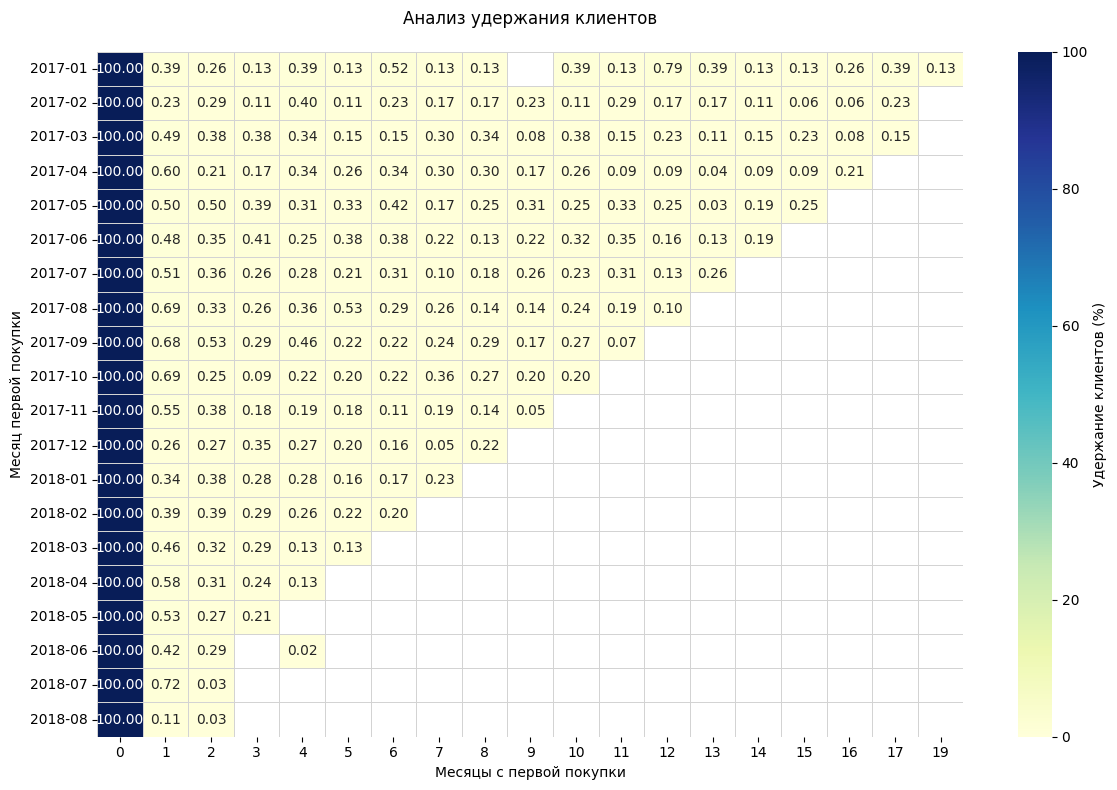

In [14]:
# 8. Визуализация
plt.figure(figsize=(12, 8))
mask = df_cohort_analysis.isnull()

sns.heatmap(
    df_cohort_analysis * 100,  # Переводим в проценты
    mask=mask,
    annot=True,
    fmt='.2f',  # Один знак после запятой
    cmap='YlGnBu',
    vmin=0,
    vmax=100,
    linewidths=0.5,
    linecolor='lightgray',
    cbar_kws={'label': 'Удержание клиентов (%)'},
    square=False
)

plt.title('Анализ удержания клиентов', pad=20)
plt.xlabel('Месяцы с первой покупки')
plt.ylabel('Месяц первой покупки')
plt.tight_layout()
plt.show()

In [15]:
# Для построения графика удержания с течением времени выполним следующие действия:

# 1. Агрегируем данные по когортам и месяцам
cohort_analysis = df.groupby(['cohort_month', 'months_since_first']).agg(
    n_customers=('customer_id', 'nunique')
).reset_index()

In [16]:
# 2. Добавляем размер когорты (количество уникальных клиентов в месяц первой покупки)
cohort_size = cohort_analysis[cohort_analysis['months_since_first'] == 0][['cohort_month', 'n_customers']]
cohort_size.columns = ['cohort_month', 'cohort_size']

cohort_analysis = pd.merge(cohort_analysis, cohort_size, on='cohort_month')

# 3. Рассчитываем Retention Rate
cohort_analysis['retention_rate'] = cohort_analysis['n_customers'] / cohort_analysis['cohort_size']

<Figure size 1200x600 with 0 Axes>

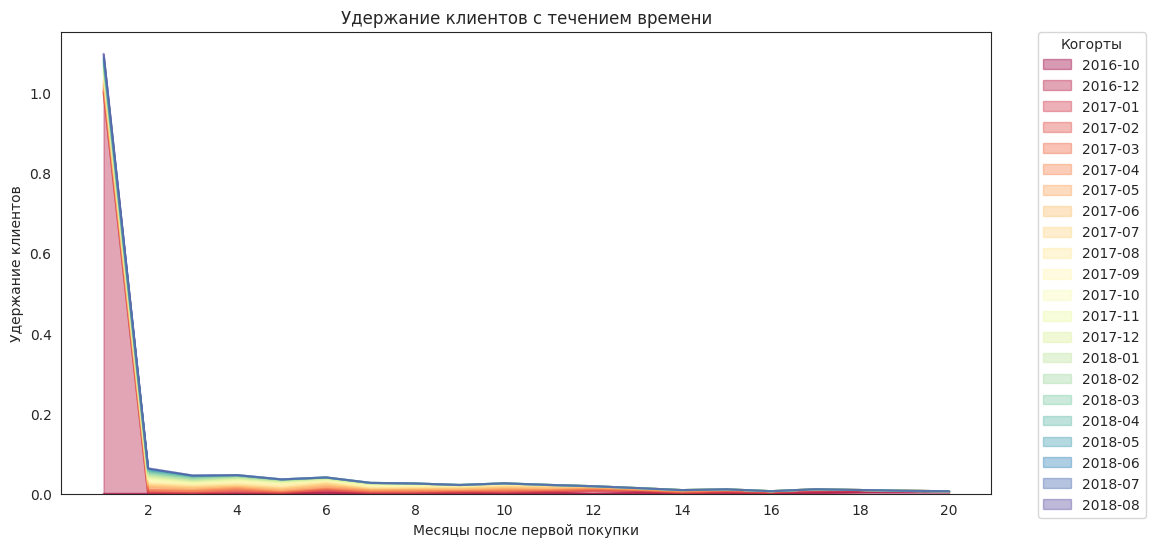

In [17]:
# 4. Фильтруем нулевой месяц (всегда 100%)
cohort_analysis = cohort_analysis[cohort_analysis['months_since_first'] > 0]

stacked_data = cohort_analysis.pivot_table(
    index='cohort_month',
    columns='months_since_first',
    values='retention_rate',
    fill_value=0
)

plt.figure(figsize=(12, 6))
sns.set_style("white")
stacked_data.T.plot(
    kind='area',
    alpha=0.4,
    figsize=(12, 6),
    colormap='Spectral'
)
# Получаем максимальное значение месяцев
max_month = stacked_data.columns.max()

# Задаем метки с шагом 2
plt.xticks(ticks=range(2, max_month+1, 2), labels=range(2, max_month+1, 2))

# Опционально: добавляем легенду справа от графика
plt.legend(
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    borderaxespad=0.,
    title='Когорты'
)

plt.title('Удержание клиентов с течением времени')
plt.xlabel('Месяцы после первой покупки')
plt.ylabel('Удержание клиентов')
plt.show()

In [18]:
# Проверка на наличии дубликатов в данных
print(f"Дубликатов в заказах: {df.duplicated(subset='order_id').sum()}")

Дубликатов в заказах: 0


In [19]:
# Должно быть 0 строк
df[(df['order_purchase_timestamp'] == df['first_order_date']) & (df['months_since_first'] != 0)]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,first_order_date,cohort_month,order_month,months_since_first


In [20]:
# Проверим сколько пользователей делали повторные покупки
repeat_users = df[df['months_since_first'] > 0]['customer_unique_id'].nunique()
print(f"Повторные покупки сделали: {repeat_users / len(cohorts):.1%} пользователей")

Повторные покупки сделали: 1.9% пользователей


In [21]:
# Объединяем с таблицей товаров
df_items = dataframes['olist_order_items_dataset']
df = pd.merge(df, df_items, on='order_id')
df_products = dataframes['olist_products_dataset']
df = pd.merge(df, df_products, on='product_id')

# Смотрим топ категорий для первых и повторных покупок
print(df[df['months_since_first'] == 0]['product_category_name'].value_counts().head())
print(df[df['months_since_first'] > 0]['product_category_name'].value_counts().head())

product_category_name
cama_mesa_banho           10780
beleza_saude               9488
esporte_lazer              8409
moveis_decoracao           8146
informatica_acessorios     7655
Name: count, dtype: int64
product_category_name
cama_mesa_banho           335
esporte_lazer             232
moveis_decoracao          188
beleza_saude              182
informatica_acessorios    172
Name: count, dtype: int64


Судя по тепловой карте анализ удержания клиентов и графику удержанием клиентов в течением времени, и списку категорий покупок можно сделать следующие выводы:
1. Большинство пользователей уходят после первой покупки
2. Повторные покупки сделали только 1.9% пользователей
3. Топ 5 категории для первых покупок относятся к категориям товарам повседневного спроса и долговременного пользования


# 2. LTV

In [22]:
# Загрузка данных
customers = dataframes['olist_customers_dataset']
orders = dataframes['olist_orders_dataset']
order_items = dataframes['olist_order_items_dataset']
order_payments = dataframes['olist_order_payments_dataset']

# Объединение таблиц
# Шаг 1: Объединяем заказы с информацией о клиентах
customer_orders = pd.merge(orders, customers, on='customer_id', how='left')

# Шаг 2: Добавляем информацию о товарах в заказах
orders_with_items = pd.merge(customer_orders, order_items, on='order_id', how='left')

# Шаг 3: Добавляем информацию о платежах
full_data = pd.merge(orders_with_items, order_payments, on='order_id', how='left')

# Оставляем только завершенные заказы
completed_orders = full_data[full_data['order_status'] == 'delivered']

In [23]:
# Преобразуем даты в формат datetime
completed_orders = completed_orders.copy()
completed_orders['order_purchase_timestamp'] = pd.to_datetime(completed_orders['order_purchase_timestamp'])

# Рассчитываем метрики активности клиентов
customer_activity = completed_orders.groupby('customer_unique_id').agg(
    first_purchase=('order_purchase_timestamp', 'min'),  # Первая покупка
    last_purchase=('order_purchase_timestamp', 'max'),   # Последняя покупка
    total_revenue=('payment_value', 'sum'),             # Сумма всех платежей
    order_count=('order_id', 'nunique')                 # Количество заказов
).reset_index()

# Рассчитываем "время жизни" клиента в днях (+1 день включает и первый, и последний день)
customer_activity['lifetime_days'] = (customer_activity['last_purchase'] - customer_activity['first_purchase']).dt.days + 1

# Рассчитываем дневной LTV (общий доход / время жизни в днях)
customer_activity['ltv'] = customer_activity['total_revenue'] / customer_activity['lifetime_days']

# Фильтруем клиентов с lifetime_days > 0 (чтобы избежать деления на ноль)
valid_customers = customer_activity[customer_activity['lifetime_days'] > 0]

# Рассчитываем средний дневной LTV
avg_daily_ltv = valid_customers['ltv'].mean()
print(f"Средний дневной LTV: {avg_daily_ltv:.2f} BRL")

# Прогнозируем годовой LTV (365 дней)
avg_annual_ltv = avg_daily_ltv * 365
print(f"Прогноз годового LTV: {avg_annual_ltv:.2f} BRL")

Средний дневной LTV: 202.31 BRL
Прогноз годового LTV: 73844.32 BRL


In [24]:
# Определяем когорты по месяцу первой покупки
customer_activity['cohort_month'] = customer_activity['first_purchase'].dt.to_period('M')

# Группируем по когортам и считаем средний LTV
cohort_ltv = customer_activity.groupby('cohort_month').agg(
    customers=('customer_unique_id', 'nunique'),
    avg_ltv=('total_revenue', 'mean'),
    avg_lifetime=('lifetime_days', 'mean')
).reset_index()

print(cohort_ltv)

   cohort_month  customers     avg_ltv  avg_lifetime
0       2016-09          1    0.000000      1.000000
1       2016-10        262  243.605687     17.209924
2       2016-12          1   39.240000     13.000000
3       2017-01        717  252.286960     13.523013
4       2017-02       1628  205.129908      7.836609
5       2017-03       2503  208.930084      8.778666
6       2017-04       2256  210.271352      7.525709
7       2017-05       3451  210.778276      8.512895
8       2017-06       3037  200.673151      8.160026
9       2017-07       3752  193.984486      6.887527
10      2017-08       4057  213.177540      6.161942
11      2017-09       4004  251.787288      5.368631
12      2017-10       4328  232.089683      4.681608
13      2017-11       7060  220.095574      2.967989
14      2017-12       5338  189.599674      2.912514
15      2018-01       6842  201.130265      2.863636
16      2018-02       6288  203.931888      2.572201
17      2018-03       6774  208.826791      1.

In [25]:
min_customer_size = 700
cohort_ltv = cohort_ltv[cohort_ltv['customers'] > min_customer_size]
cohort_ltv

,cohort_month,customers,avg_ltv,avg_lifetime
3,2017-01,717,252.286960,13.523013
4,2017-02,1628,205.129908,7.836609
5,2017-03,2503,208.930084,8.778666
6,2017-04,2256,210.271352,7.525709
7,2017-05,3451,210.778276,8.512895
8,2017-06,3037,200.673151,8.160026
9,2017-07,3752,193.984486,6.887527
10,2017-08,4057,213.177540,6.161942
11,2017-09,4004,251.787288,5.368631
12,2017-10,4328,232.089683,4.681608


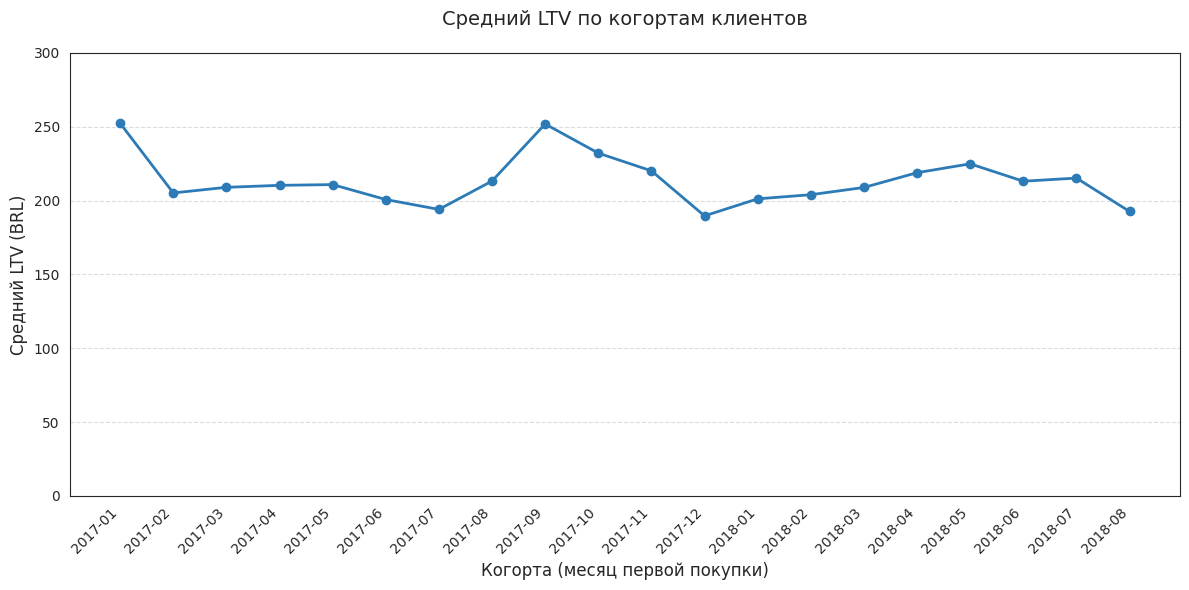

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# График с настройками
plt.plot(cohort_ltv['cohort_month'].astype(str),
         cohort_ltv['avg_ltv'],
         marker='o',  # Добавляем точки на линию
         linewidth=2,
         color='#2c7bb6')

# Настройка осей и заголовков
plt.title('Средний LTV по когортам клиентов', pad=20, fontsize=14)
plt.xlabel('Когорта (месяц первой покупки)', fontsize=12)
plt.ylabel('Средний LTV (BRL)', fontsize=12)
plt.xticks(rotation=45, ha='right')  # Наклон подписей с выравниванием
plt.ylim(0,300)  # Ось Y начинается с 0

# Сетка для удобства чтения
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Автоматическая подгонка макета
plt.tight_layout()
plt.show()

# 3. Средний чек

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Загрузка данных
customers = dataframes['olist_customers_dataset']
orders = dataframes['olist_orders_dataset']
order_items = dataframes['olist_order_items_dataset']
order_payments = dataframes['olist_order_payments_dataset']

# Объединение данных
data = pd.merge(orders, customers, on='customer_id', how='left')
data = pd.merge(data, order_payments, on='order_id', how='left')

# Фильтрация завершенных заказов
completed_orders = data[data['order_status'] == 'delivered'].copy()

# Преобразование даты
completed_orders['order_purchase_timestamp'] = pd.to_datetime(completed_orders['order_purchase_timestamp'])
completed_orders['purchase_month'] = completed_orders['order_purchase_timestamp'].dt.to_period('M')

In [28]:
# Определяем когорту (месяц первой покупки для каждого клиента)
first_purchases = completed_orders.groupby('customer_unique_id')['order_purchase_timestamp'].min().reset_index()
first_purchases['cohort_month'] = first_purchases['order_purchase_timestamp'].dt.to_period('M')

# Добавляем информацию о когорте в основной датафрейм
completed_orders = pd.merge(completed_orders, first_purchases[['customer_unique_id', 'cohort_month']],
                           on='customer_unique_id', how='left')

# Рассчитываем период (месяц) относительно когорты
completed_orders['cohort_index'] = (completed_orders['purchase_month'] - completed_orders['cohort_month']).apply(lambda x: x.n)

In [29]:
 # Средний чек на заказ по когортам
avg_order_value = completed_orders.groupby(['cohort_month', 'order_id'])['payment_value'].sum().reset_index()
avg_order_value = avg_order_value.groupby('cohort_month')['payment_value'].mean().reset_index()
avg_order_value.columns = ['cohort_month', 'avg_order_value']

print("Средний чек по когортам:")
print(avg_order_value.sort_values('cohort_month'))

Средний чек по когортам:
   cohort_month  avg_order_value
0       2016-09         0.000000
1       2016-10       175.699636
2       2016-12        19.620000
3       2017-01       167.277803
4       2017-02       163.346096
5       2017-03       162.249202
6       2017-04       170.352831
7       2017-05       159.172319
8       2017-06       156.445670
9       2017-07       145.983111
10      2017-08       153.876510
11      2017-09       168.175894
12      2017-10       167.698614
13      2017-11       158.607616
14      2017-12       152.713253
15      2018-01       152.365906
16      2018-02       147.900263
17      2018-03       160.177287
18      2018-04       166.637437
19      2018-05       168.073498
20      2018-06       165.837676
21      2018-07       167.010820
22      2018-08       155.817633


In [30]:
# Частота покупок (среднее количество заказов на клиента)
purchase_frequency = completed_orders.groupby(['cohort_month', 'customer_unique_id'])['order_id'].nunique().reset_index()
purchase_frequency = purchase_frequency.groupby('cohort_month')['order_id'].mean().reset_index()
purchase_frequency.columns = ['cohort_month', 'purchase_frequency']

print("\nЧастота покупок по когортам (среднее количество заказов на клиента):")
print(purchase_frequency.sort_values('cohort_month'))


Частота покупок по когортам (среднее количество заказов на клиента):
   cohort_month  purchase_frequency
0       2016-09            1.000000
1       2016-10            1.049618
2       2016-12            2.000000
3       2017-01            1.092050
4       2017-02            1.044840
5       2017-03            1.056332
6       2017-04            1.049202
7       2017-05            1.062301
8       2017-06            1.062232
9       2017-07            1.053838
10      2017-08            1.055953
11      2017-09            1.052947
12      2017-10            1.041590
13      2017-11            1.034278
14      2017-12            1.027913
15      2018-01            1.032154
16      2018-02            1.040872
17      2018-03            1.025539
18      2018-04            1.020662
19      2018-05            1.017522
20      2018-06            1.012589
21      2018-07            1.014960
22      2018-08            1.005859


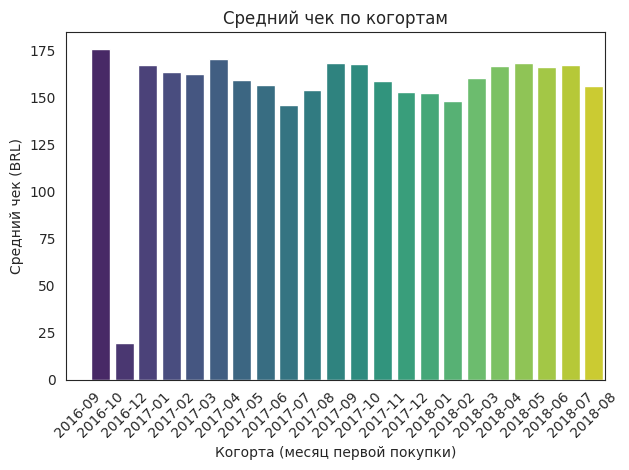

In [34]:
# График среднего чека по когортам
sns.barplot(x='cohort_month', y='avg_order_value', data=avg_order_value, palette='viridis', hue='cohort_month', legend=False)
plt.title('Средний чек по когортам')
plt.xlabel('Когорта (месяц первой покупки)')
plt.ylabel('Средний чек (BRL)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

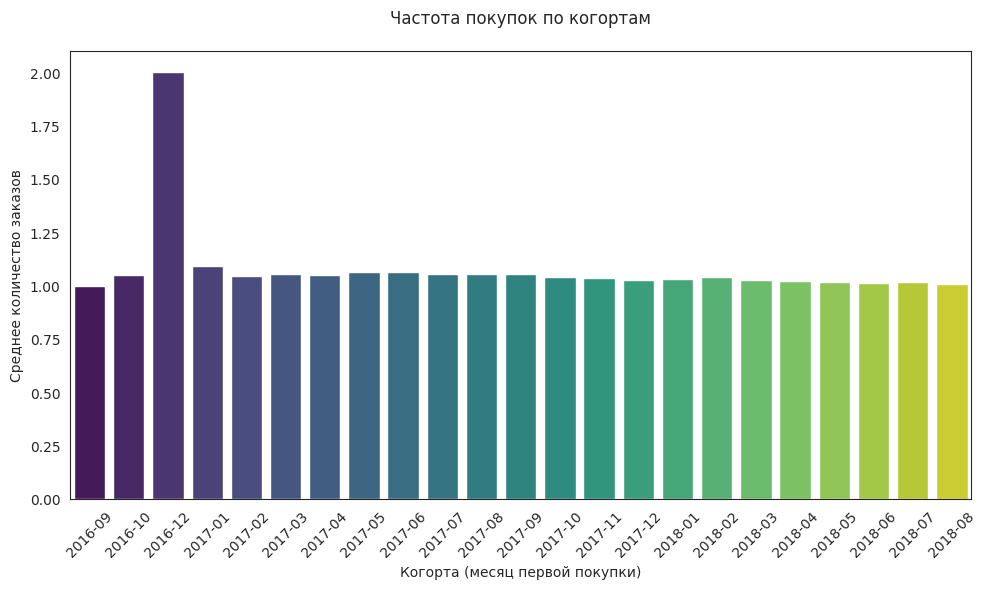

In [32]:
# График частоты покупок по когортам
plt.figure(figsize=(10, 6))
sns.barplot(
    x='cohort_month',
    y='purchase_frequency',
    hue='cohort_month',
    data=purchase_frequency,
    palette='viridis',
    legend=False
)
plt.title('Частота покупок по когортам', pad=20)
plt.xlabel('Когорта (месяц первой покупки)')
plt.ylabel('Среднее количество заказов')
plt.xticks(rotation=45)



plt.tight_layout()
plt.show()

Основные выводы:
1. Доминирование разовых покупок.
Большинство клиентов совершают только 1 заказ (коэффициент близок к 1).
Менее 1.9% пользователей делают повторные заказы.

2. Проблемы удержания.
Низкая лояльность клиентов.
Отсутствие эффективной системы повторного вовлечения (email-рассылки, программы лояльности).
Возможно, продукт не требует частых повторных покупок (например, мебель или электроника)

3. Экономические последствия.
Высокие затраты на привлечение новых клиентов (CAC) не окупаются.
Низкий LTV (пожизненная ценность клиента).

Рекомендации по улучшению:
1. Стимулирование повторных покупок
Персонализированные предложения:

Купоны на второй заказ (например, "10% скидки на следующую покупку в течение 30 дней"),

Рекомендации на основе истории покупок ("К этому товару часто берут...").

Подписки и регулярные заказы:

Для категорий вроде "красота/здоровье" или "товары для дома" предложить подписку с автоматическим пополнением.

2. Улучшение клиентского опыта
Постпродажная поддержка:

Отслеживание доставки, напоминания о гарантии, запрос отзывов.

Программы лояльности:

Накопительные бонусы (например, "5% кэшбэка за каждый заказ").

3. Анализ причин низкого удержания
Опросы клиентов:

Почему не вернулись? (цена, качество, сервис?)

Сегментация данных:

Есть ли категории товаров с более высоким повторным спросом? Например, "бытовая химия" vs "мебель".

4. Оптимизация маркетинга
Ретаргетинг:

Напоминания для "уснувших" клиентов (например, "В вашей корзине остались товары!").

Реферальные программы:

"Приведи друга — получи скидку".